In [76]:
from pyspark.sql import functions as sqlfunctions
from graphframes import GraphFrame
from graphframes import *
import networkx as nx
import matplotlib.pyplot as plt
from graphframes.examples import Graphs


from pyspark.sql.functions import sum as sqlsum
from graphframes.lib import AggregateMessages as AM

# Creating Graphframes

In [42]:
spark = SparkSession.builder.appName('fun').getOrCreate()

vertices = spark.createDataFrame([('1', 'Carter', 'Derrick', 50), 
                                  ('2', 'May', 'Derrick', 26),
                                 ('3', 'Mills', 'Jeff', 80),
                                  ('4', 'Hood', 'Robert', 65),
                                  ('5', 'Banks', 'Mike', 93),
                                 ('98', 'Berg', 'Tim', 28),
                                 ('99', 'Page', 'Allan', 16)],
                                 ['id', 'name', 'firstname', 'age'])
edges = spark.createDataFrame([('1', '2', 'friend'), 
                               ('2', '1', 'friend'),
                              ('3', '1', 'friend'),
                              ('1', '3', 'friend'),
                               ('2', '3', 'follows'),
                               ('3', '4', 'friend'),
                               ('4', '3', 'friend'),
                               ('5', '3', 'friend'),
                               ('3', '5', 'friend'),
                               ('4', '5', 'follows'),
                              ('98', '99', 'friend'),
                              ('99', '98', 'friend')],
                              ['src', 'dst', 'type'])
g = GraphFrame(vertices, edges)

In [38]:
## Plot the graph
def PlotGraph(edge_list):
    Gplot=nx.DiGraph()
    for row in edge_list.select('src','dst').take(1000):
        Gplot.add_edge(row['src'],row['dst'])

#     plt.subplot(121)
    nx.draw(Gplot, with_labels=True, font_weight='bold')

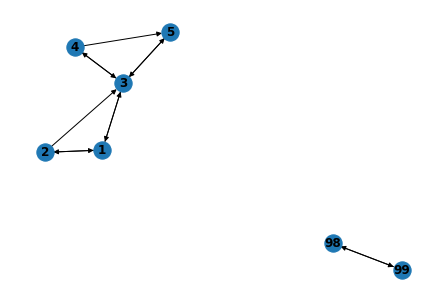

In [39]:
PlotGraph(g.edges)

# Basic Queries

In [24]:
g.vertices

DataFrame[id: string, name: string, firstname: string, age: bigint]

In [4]:
g.vertices.show()

+---+------+---------+---+
| id|  name|firstname|age|
+---+------+---------+---+
|  1|Carter|  Derrick| 50|
|  2|   May|  Derrick| 26|
|  3| Mills|     Jeff| 80|
|  4|  Hood|   Robert| 65|
|  5| Banks|     Mike| 93|
| 98|  Berg|      Tim| 28|
| 99|  Page|    Allan| 16|
+---+------+---------+---+



In [5]:
g.edges.show()

+---+---+-------+
|src|dst|   type|
+---+---+-------+
|  1|  2| friend|
|  2|  1| friend|
|  3|  1| friend|
|  1|  3| friend|
|  2|  3|follows|
|  3|  4| friend|
|  4|  3| friend|
|  5|  3| friend|
|  3|  5| friend|
|  4|  5|follows|
| 98| 99| friend|
| 99| 98| friend|
+---+---+-------+



In [19]:
# Get a DataFrame with columns "id" and "inDegree" (in-degree)
vertexInDegrees = g.inDegrees
vertexInDegrees.show()

+---+--------+
| id|inDegree|
+---+--------+
|  2|       1|
|  1|       2|
|  3|       4|
|  4|       1|
|  5|       2|
| 98|       1|
| 99|       1|
+---+--------+



In [6]:
## Check the number of edges of each vertex
g.degrees.show()

C:\Spark\spark\python\pyspark\sql\dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+---+------+
| id|degree|
+---+------+
|  1|     4|
|  2|     3|
|  3|     7|
|  4|     3|
|  5|     3|
| 98|     2|
| 99|     2|
+---+------+



In [20]:
# Find the youngest user's age in the graph.
# This queries the vertex DataFrame.
g.vertices.groupBy().min("age").show()

+--------+
|min(age)|
+--------+
|      16|
+--------+



## Filtering

In [28]:
numFollows = g.edges.filter("type = 'follows'").count()
numFollows

2

In [44]:
g.vertices.filter("age > 30").show()

+---+------+---------+---+
| id|  name|firstname|age|
+---+------+---------+---+
|  1|Carter|  Derrick| 50|
|  3| Mills|     Jeff| 80|
|  4|  Hood|   Robert| 65|
|  5| Banks|     Mike| 93|
+---+------+---------+---+



In [45]:
g.inDegrees.filter("inDegree >= 2").sort("inDegree", ascending=False).show()

+---+--------+
| id|inDegree|
+---+--------+
|  3|       4|
|  1|       2|
|  5|       2|
+---+--------+



In [47]:
g.edges.filter('type == "friend"').show()

+---+---+------+
|src|dst|  type|
+---+---+------+
|  1|  2|friend|
|  2|  1|friend|
|  3|  1|friend|
|  1|  3|friend|
|  3|  4|friend|
|  4|  3|friend|
|  5|  3|friend|
|  3|  5|friend|
| 98| 99|friend|
| 99| 98|friend|
+---+---+------+



# Motif Finding

Motif finding refers to searching for structural patterns in a graph. 
GraphFrame motif finding uses a simple Domain-Specific Language (DSL) for expressing structural queries. For example, graph.find("(a)-[e]->(b); (b)-[e2]->(a)") will search for pairs of vertices a,b connected by edges in both directions. It will return a DataFrame of all such structures in the graph, with columns for each of the named elements (vertices or edges) in the motif. In this case, the returned columns will be “a, b, e, e2.”

USAGE: Finding motifs helps to execute queries to discover structural patterns in graphs. Network motifs are patterns that occur repeatedly in the graph and represent the relationships between the vertices

In [51]:
motifs = g.find("(a)-[e]->(b); (b)-[e2]->(a)")
motifs.show()



+--------------------+----------------+--------------------+----------------+
|                   a|               e|                   b|              e2|
+--------------------+----------------+--------------------+----------------+
|{2, May, Derrick,...|  {2, 1, friend}|{1, Carter, Derri...|  {1, 2, friend}|
|{3, Mills, Jeff, 80}|  {3, 1, friend}|{1, Carter, Derri...|  {1, 3, friend}|
|{1, Carter, Derri...|  {1, 2, friend}|{2, May, Derrick,...|  {2, 1, friend}|
|{1, Carter, Derri...|  {1, 3, friend}|{3, Mills, Jeff, 80}|  {3, 1, friend}|
|{4, Hood, Robert,...|  {4, 3, friend}|{3, Mills, Jeff, 80}|  {3, 4, friend}|
|{5, Banks, Mike, 93}|  {5, 3, friend}|{3, Mills, Jeff, 80}|  {3, 5, friend}|
|{3, Mills, Jeff, 80}|  {3, 4, friend}|{4, Hood, Robert,...|  {4, 3, friend}|
|{3, Mills, Jeff, 80}|  {3, 5, friend}|{5, Banks, Mike, 93}|  {5, 3, friend}|
|{99, Page, Allan,...|{99, 98, friend}| {98, Berg, Tim, 28}|{98, 99, friend}|
| {98, Berg, Tim, 28}|{98, 99, friend}|{99, Page, Allan,...|{99,

In [54]:
# More complex queries can be expressed by applying filters.
motifs.filter("b.age > 30").show()

+--------------------+--------------+--------------------+--------------+
|                   a|             e|                   b|            e2|
+--------------------+--------------+--------------------+--------------+
|{2, May, Derrick,...|{2, 1, friend}|{1, Carter, Derri...|{1, 2, friend}|
|{3, Mills, Jeff, 80}|{3, 1, friend}|{1, Carter, Derri...|{1, 3, friend}|
|{1, Carter, Derri...|{1, 3, friend}|{3, Mills, Jeff, 80}|{3, 1, friend}|
|{4, Hood, Robert,...|{4, 3, friend}|{3, Mills, Jeff, 80}|{3, 4, friend}|
|{5, Banks, Mike, 93}|{5, 3, friend}|{3, Mills, Jeff, 80}|{3, 5, friend}|
|{3, Mills, Jeff, 80}|{3, 4, friend}|{4, Hood, Robert,...|{4, 3, friend}|
|{3, Mills, Jeff, 80}|{3, 5, friend}|{5, Banks, Mike, 93}|{5, 3, friend}|
+--------------------+--------------+--------------------+--------------+



##  find the mutual friends for any pair of users a and c

In [52]:
mutualFriends = g.find("(a)-[]->(b); (b)-[]->(c); (c)-[]->(b); (b)-[]->(a)")\
.dropDuplicates()

In [53]:
mutualFriends.filter('a.id == 2 and c.id == 3').show()

+--------------------+--------------------+--------------------+
|                   a|                   b|                   c|
+--------------------+--------------------+--------------------+
|{2, May, Derrick,...|{1, Carter, Derri...|{3, Mills, Jeff, 80}|
+--------------------+--------------------+--------------------+



# Subgraphs

In GraphX, the subgraph() method takes an edge triplet (edge, src vertex, and dst vertex, plus attributes) and allows the user to select a subgraph based on triplet and vertex filters.

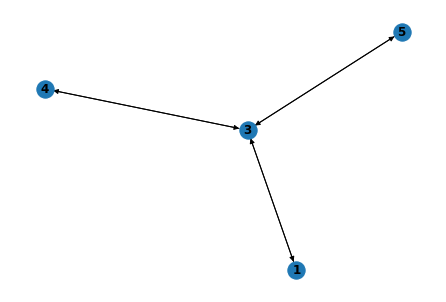

In [57]:
g1 = g.filterVertices("age > 30").filterEdges("type = 'friend'").dropIsolatedVertices()
PlotGraph(g1.edges)

# Graph Algorithms

## Breadth First Search (BFS)

In [58]:
# Search from "Mills" for users of age < 32.
paths = g.bfs("name = 'Mills'", "age < 32")
paths.show()


+--------------------+--------------+--------------------+--------------+--------------------+
|                from|            e0|                  v1|            e1|                  to|
+--------------------+--------------+--------------------+--------------+--------------------+
|{3, Mills, Jeff, 80}|{3, 1, friend}|{1, Carter, Derri...|{1, 2, friend}|{2, May, Derrick,...|
+--------------------+--------------+--------------------+--------------+--------------------+



In [60]:
# Specify edge filters or max path lengths.
g.bfs("name = 'Esther'", "age < 32",\
  edgeFilter="relationship != 'friend'", maxPathLength=3).show()

+---+----+---------+---+
| id|name|firstname|age|
+---+----+---------+---+
+---+----+---------+---+



## Connected components of the graph

Connected components detection can be interesting for clustering, but also to make your computations more efficient.

In [49]:
# set the checkpoint directory.
sc.setCheckpointDir('graphframes_cps')

In [50]:
g.connectedComponents().show()

+---+------+---------+---+------------+
| id|  name|firstname|age|   component|
+---+------+---------+---+------------+
|  1|Carter|  Derrick| 50|154618822656|
|  2|   May|  Derrick| 26|154618822656|
|  3| Mills|     Jeff| 80|154618822656|
|  4|  Hood|   Robert| 65|154618822656|
|  5| Banks|     Mike| 93|154618822656|
| 98|  Berg|      Tim| 28|317827579904|
| 99|  Page|    Allan| 16|317827579904|
+---+------+---------+---+------------+



## Triangle Count

In [61]:
g.triangleCount().show()

+-----+---+------+---------+---+
|count| id|  name|firstname|age|
+-----+---+------+---------+---+
|    1|  1|Carter|  Derrick| 50|
|    1|  2|   May|  Derrick| 26|
|    2|  3| Mills|     Jeff| 80|
|    1|  4|  Hood|   Robert| 65|
|    1|  5| Banks|     Mike| 93|
|    0| 98|  Berg|      Tim| 28|
|    0| 99|  Page|    Allan| 16|
+-----+---+------+---------+---+



## Shortest paths


In [68]:
results = g.shortestPaths(landmarks=["1", "3"])

In [69]:
results.show()

+---+------+---------+---+----------------+
| id|  name|firstname|age|       distances|
+---+------+---------+---+----------------+
|  3| Mills|     Jeff| 80|{1 -> 1, 3 -> 0}|
| 98|  Berg|      Tim| 28|              {}|
| 99|  Page|    Allan| 16|              {}|
|  5| Banks|     Mike| 93|{1 -> 2, 3 -> 1}|
|  1|Carter|  Derrick| 50|{1 -> 0, 3 -> 1}|
|  4|  Hood|   Robert| 65|{1 -> 2, 3 -> 1}|
|  2|   May|  Derrick| 26|{1 -> 1, 3 -> 1}|
+---+------+---------+---+----------------+



## PageRank

In [70]:
pagerank = g.pageRank(resetProbability=0.15, maxIter=10)
pagerank.vertices.select("id", "pagerank").show()


+---+------------------+
| id|          pagerank|
+---+------------------+
|  3|1.8872102677908136|
| 98|1.0000000000000002|
| 99|1.0000000000000002|
|  5|0.9758414453949464|
|  1|0.9144332361140216|
|  4| 0.685007724175069|
|  2|0.5375073265251489|
+---+------------------+



In [71]:
pagerank.edges.select("src", "dst", "weight").show()

+---+---+------------------+
|src|dst|            weight|
+---+---+------------------+
|  3|  5|0.3333333333333333|
|  3|  1|0.3333333333333333|
|  3|  4|0.3333333333333333|
| 98| 99|               1.0|
| 99| 98|               1.0|
|  5|  3|               1.0|
|  1|  3|               0.5|
|  1|  2|               0.5|
|  4|  3|               0.5|
|  4|  5|               0.5|
|  2|  3|               0.5|
|  2|  1|               0.5|
+---+---+------------------+



Run PageRank personalized for vertex "1"

In [72]:
pagerank2 = g.pageRank(resetProbability=0.15, maxIter=10, sourceId="1")
pagerank2.vertices.show()

+---+------+---------+---+-------------------+
| id|  name|firstname|age|           pagerank|
+---+------+---------+---+-------------------+
|  3| Mills|     Jeff| 80|0.33891806394017526|
| 98|  Berg|      Tim| 28|                0.0|
| 99|  Page|    Allan| 16|                0.0|
|  5| Banks|     Mike| 93|0.13689847609530284|
|  1|Carter|  Derrick| 50|0.30079283470815427|
|  4|  Hood|   Robert| 65|0.09616868544059574|
|  2|   May|  Derrick| 26| 0.1272219398157718|
+---+------+---------+---+-------------------+



# Message passing via AggregateMessages


Like GraphX, GraphFrames provides primitives for developing graph algorithms. The two key components are:

* aggregateMessages: Send messages between vertices, and aggregate messages for each vertex. GraphFrames provides a native aggregateMessages method implemented using DataFrame operations. This may be used analogously to the GraphX API.
* joins: Join message aggregates with the original graph. GraphFrames rely on DataFrame joins, which provide the full functionality of GraphX joins.

In [77]:
# For each user, sum the ages of the adjacent users.
msgToSrc = AM.dst["age"]
msgToDst = AM.src["age"]
agg = g.aggregateMessages(
    sqlsum(AM.msg).alias("summedAges"),
    sendToSrc=msgToSrc,
    sendToDst=msgToDst)
agg.show()

+---+----------+
| id|summedAges|
+---+----------+
|  3|       442|
| 98|        32|
| 99|        56|
|  5|       225|
|  1|       212|
|  4|       253|
|  2|       180|
+---+----------+

